In [ ]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb


Load and Inspect the **Dataset**

In [ ]:
# Load your dataset
df = pd.read_csv('/content/IKEA_SA_Furniture_Web_Scrapings_sss.csv')

# Show the first 5 rows of the dataset
df.head()

# Get summary information about the dataset (e.g., column types, number of missing values)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3694 entries, 0 to 3693
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         3694 non-null   int64  
 1   item_id            3694 non-null   int64  
 2   name               3694 non-null   object 
 3   category           3694 non-null   object 
 4   price              3694 non-null   float64
 5   old_price          3694 non-null   object 
 6   sellable_online    3694 non-null   bool   
 7   link               3694 non-null   object 
 8   other_colors       3694 non-null   object 
 9   short_description  3694 non-null   object 
 10  designer           3694 non-null   object 
 11  depth              2231 non-null   float64
 12  height             2706 non-null   float64
 13  width              3105 non-null   float64
dtypes: bool(1), float64(4), int64(2), object(7)
memory usage: 378.9+ KB


Handle Missing Values (Cleaning)

In [ ]:
# Identify numeric columns
numeric_columns = df.select_dtypes(include=[np.number]).columns
print("Numeric columns:", numeric_columns)

# Identify non-numeric columns
non_numeric_columns = df.select_dtypes(exclude=[np.number]).columns
print("Non-numeric columns:", non_numeric_columns)

# Fill missing values for numeric columns with the mean
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

# For non-numeric columns, fill missing values with the most frequent value (mode)
for column in non_numeric_columns:
    df[column] = df[column].fillna(df[column].mode()[0])

# Check if there are any missing values left
print(df.isnull().sum())





Numeric columns: Index(['Unnamed: 0', 'item_id', 'price', 'depth', 'height', 'width'], dtype='object')
Non-numeric columns: Index(['name', 'category', 'old_price', 'sellable_online', 'link',
       'other_colors', 'short_description', 'designer'],
      dtype='object')
Unnamed: 0           0
item_id              0
name                 0
category             0
price                0
old_price            0
sellable_online      0
link                 0
other_colors         0
short_description    0
designer             0
depth                0
height               0
width                0
dtype: int64


Outlier Detection and Removal

In [ ]:
# Detecting and removing outliers using IQR
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

# Check after removing outliers
df.shape


(3418, 14)

Feature Encoding

In [ ]:
# Apply One-Hot Encoding to categorical features
columns=['item_id', 'height', 'category', 'price']
X=pd.get_dummies(df, columns=['price'], drop_first=True)
# df_encoded = pd.get_dummies(df, columns=['item_id', 'height', 'category'], drop_first=True)
df_encoded = df[columns]

# Display the encoded dataset
df_encoded.head()


,item_id,height,category,price
0,90420332,99.00000,Bar furniture,265.0
1,368814,105.00000,Bar furniture,995.0
2,9333523,101.67997,Bar furniture,2095.0
3,80155205,100.00000,Bar furniture,69.0
4,30180504,43.00000,Bar furniture,225.0


Train-Test Split

In [ ]:
# Define features and target variable
# X = df_encoded.drop('price', axis=1)
# X = df_encoded
y = df_encoded['price']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# print(x)
# x=df_encoded.drop('price', axis=1)
# x

**Exploratory Data Analysis**

 Distribution of Prices


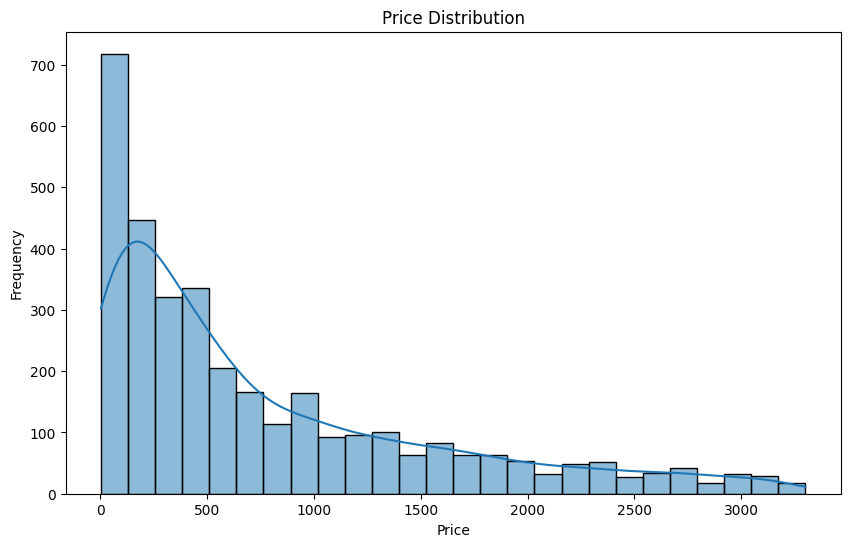

In [ ]:
# Plot the distribution of prices
plt.figure(figsize=(10,6))
sns.histplot(df['price'], kde=True)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()


Correlation Analysis

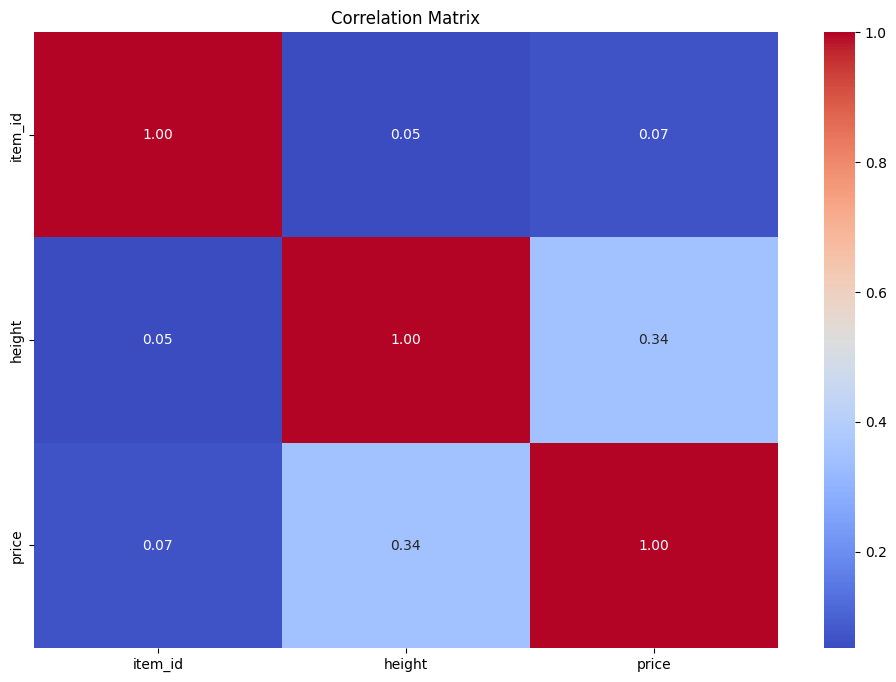

In [ ]:
df_numeric = df_encoded.select_dtypes(include=[np.number])

# Compute the correlation matrix
correlation_matrix = df_numeric.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


 Boxplots for Feature-Price Relationships

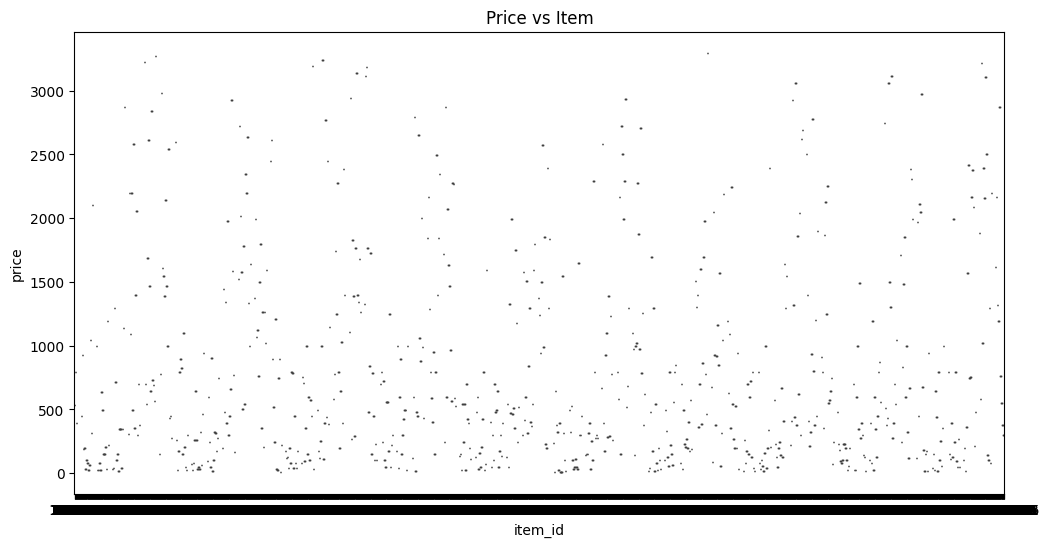

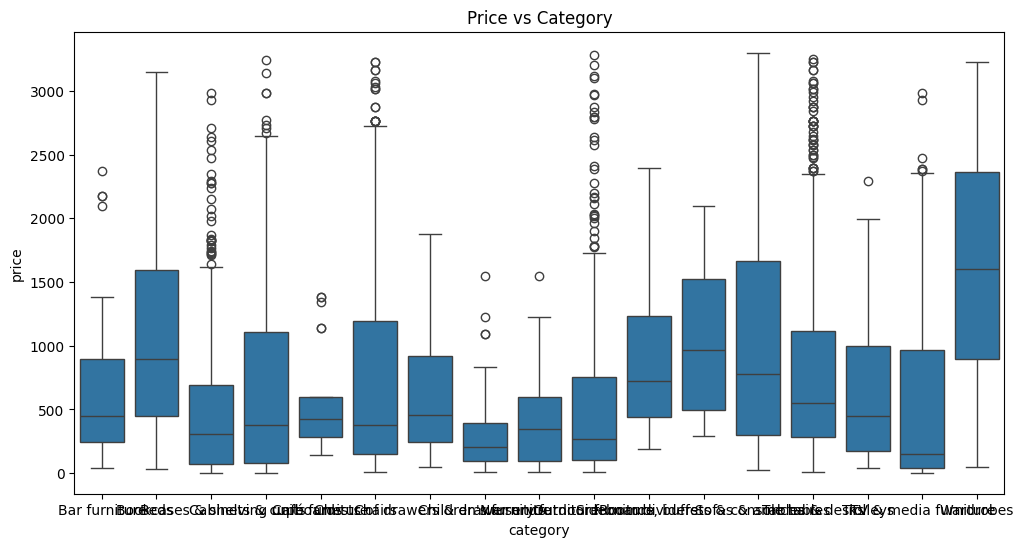

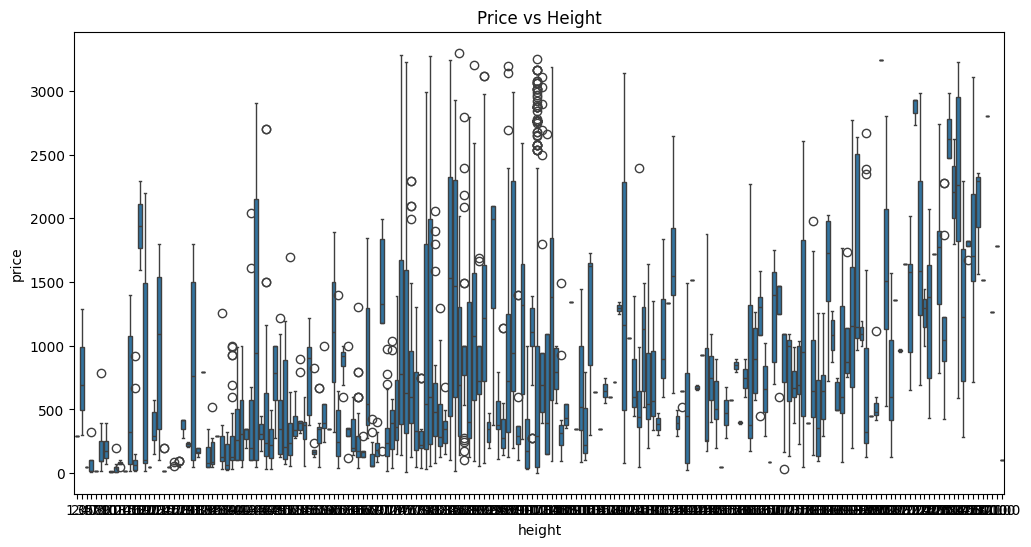

In [ ]:
# Boxplot for Material and Price
plt.figure(figsize=(12,6))
sns.boxplot(x='item_id', y='price', data=df)
plt.title('Price vs Item')
plt.show()

# Boxplot for Category and Price
plt.figure(figsize=(12,6))
sns.boxplot(x='category', y='price', data=df)
plt.title('Price vs Category')
plt.show()

# Boxplot for Size and Price
plt.figure(figsize=(12,6))
sns.boxplot(x='height', y='price', data=df)
plt.title('Price vs Height')
plt.show()


**Model Selection and Training**

Linear Regression Model

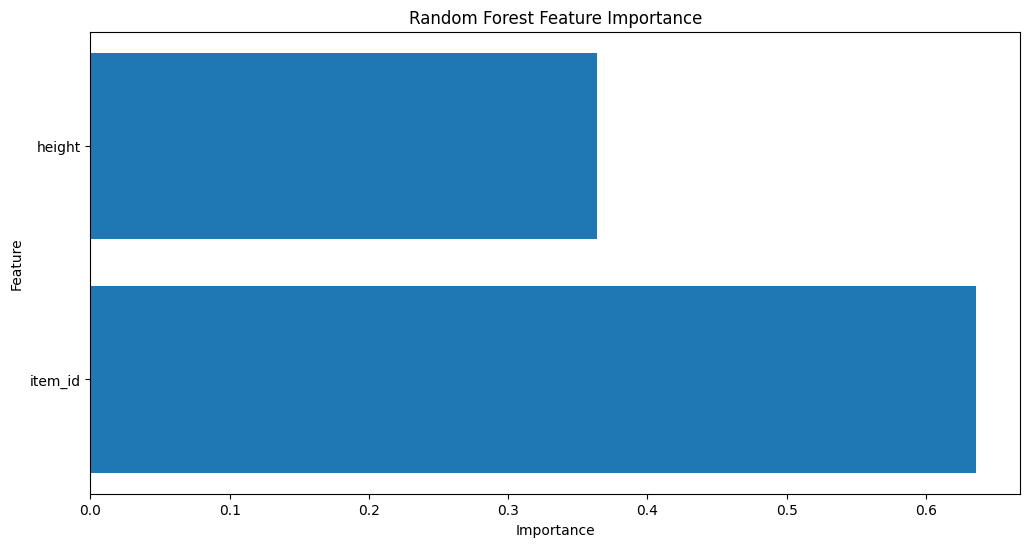

In [ ]:
categorical_columns = ['item_id', 'height']

# X_encoded = pd.get_dummies(X, columns=categorical_columns, drop_first=True)
X_encoded = X[categorical_columns]
# Train the Random Forest model again with the correctly encoded dataset
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_encoded, y)

# Get feature importances
rf_importance = rf_regressor.feature_importances_

# Create a DataFrame to associate feature names with their importance scores
feature_importance_df = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Importance': rf_importance
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()




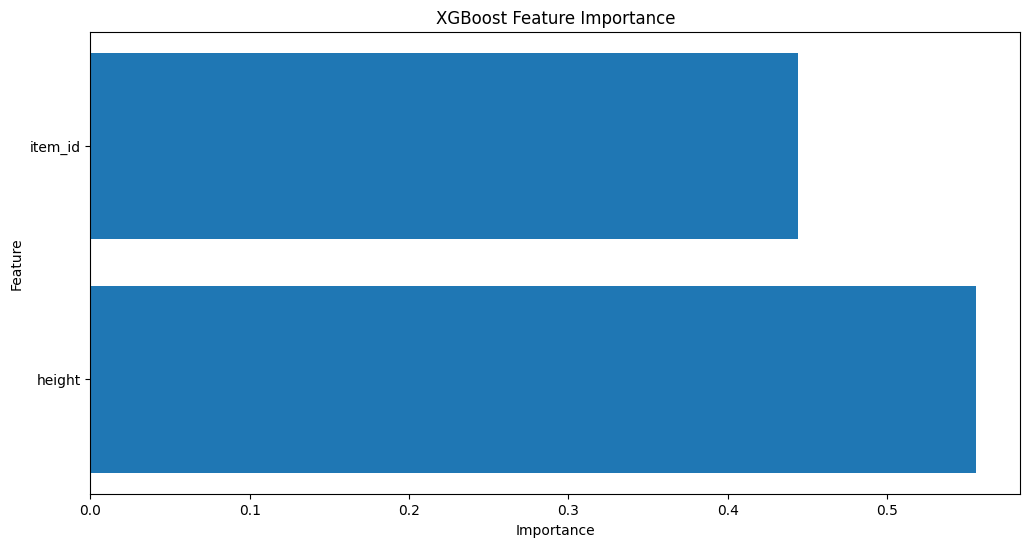

In [ ]:
# Import XGBoost
import xgboost as xgb

# Train the XGBoost model
xg_regressor = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xg_regressor.fit(X_encoded, y)

# Get feature importances from XGBoost
xgb_importance = xg_regressor.feature_importances_

# Create a DataFrame to associate feature names with their importance scores
feature_importance_df_xgb = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Importance': xgb_importance
})

# Sort by importance
feature_importance_df_xgb = feature_importance_df_xgb.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df_xgb['Feature'], feature_importance_df_xgb['Importance'])
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [ ]:
# Evaluation metrics for all three models: Linear Regression, Random Forest, and XGBoost

# Linear Regression Model Evaluation
mae_lin_reg = mean_absolute_error(y_test, y_pred_lin_reg)
rmse_lin_reg = np.sqrt(mean_squared_error(y_test, y_pred_lin_reg))
r2_lin_reg = r2_score(y_test, y_pred_lin_reg)

# Random Forest Model Evaluation
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

# XGBoost Model Evaluation
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

# Displaying Evaluation Results
print("=== Model Evaluation Results ===\n")
print(f"Linear Regression:")
print(f" - MAE: {mae_lin_reg:.2f}")
print(f" - RMSE: {rmse_lin_reg:.2f}")
print(f" - R²: {r2_lin_reg:.2f}\n")

print(f"Random Forest Regressor:")
print(f" - MAE: {mae_rf:.2f}")
print(f" - RMSE: {rmse_rf:.2f}")
print(f" - R²: {r2_rf:.2f}\n")

print(f"XGBoost Regressor:")
print(f" - MAE: {mae_xgb:.2f}")
print(f" - RMSE: {rmse_xgb:.2f}")
print(f" - R²: {r2_xgb:.2f}\n")


=== Model Evaluation Results ===

Linear Regression:
 - MAE: 190.97
 - RMSE: 321.87
 - R²: 0.82

Random Forest Regressor:
 - MAE: 220.86
 - RMSE: 371.17
 - R²: 0.76

XGBoost Regressor:
 - MAE: 230.72
 - RMSE: 342.40
 - R²: 0.79



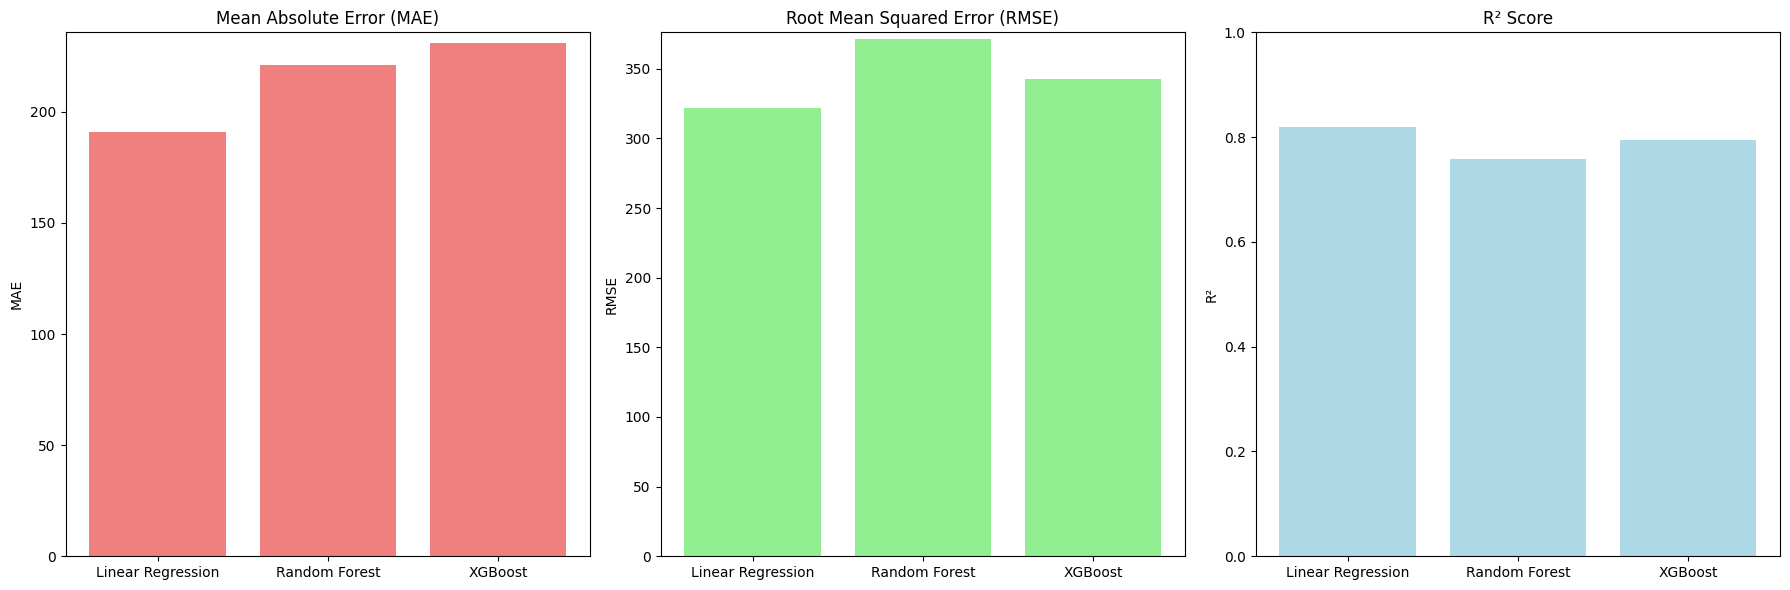

In [ ]:
# Plotting the performance metrics of all three models
metrics = ['MAE', 'RMSE', 'R²']
models = ['Linear Regression', 'Random Forest', 'XGBoost']

# Values for each metric
mae_values = [mae_lin_reg, mae_rf, mae_xgb]
rmse_values = [rmse_lin_reg, rmse_rf, rmse_xgb]
r2_values = [r2_lin_reg, r2_rf, r2_xgb]

# Plotting the MAE, RMSE, and R² for all models
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# MAE plot
axes[0].bar(models, mae_values, color='lightcoral')
axes[0].set_title('Mean Absolute Error (MAE)')
axes[0].set_ylabel('MAE')
axes[0].set_ylim(0, max(mae_values) + 5)

# RMSE plot
axes[1].bar(models, rmse_values, color='lightgreen')
axes[1].set_title('Root Mean Squared Error (RMSE)')
axes[1].set_ylabel('RMSE')
axes[1].set_ylim(0, max(rmse_values) + 5)

# R² plot
axes[2].bar(models, r2_values, color='lightblue')
axes[2].set_title('R² Score')
axes[2].set_ylabel('R²')
axes[2].set_ylim(0, 1)

plt.tight_layout()
plt.show()
